In [1]:
using DrWatson
@quickactivate "RL"

In [2]:
using Debugger
break_on(:error, :throw)

using Revise
using ReinforcementLearning
using Flux
using Statistics
using Random
using DataFrames
using CSV
using LoggingExtras

In [3]:
includet(srcdir("utils.jl"))
includet(srcdir("4_distinct_ports_env.jl"))
includet(srcdir("CustomHooks.jl"))
includet(srcdir("plotting.jl"))
io, logger = logging(Logging.Info)

(IOStream(<file /home/apierre/Dev/RL/data/logs.txt>), TransformerLogger{SimpleLogger, var"#1#3"{String}}(var"#1#3"{String}("yyyy-mm-dd HH:MM:SS"), SimpleLogger(IOStream(<file /home/apierre/Dev/RL/data/logs.txt>), Info, Dict{Any, Int64}())))

In [4]:
n_runs = 10
n_episodes = 200
title = "4 ports model"
# Random.seed!(42)


env, _, _ = four_distinct_ports_env()
NS, NA = length(state_space(env)), length(action_space(env))

learner = MonteCarloLearner(;
    approximator = TabularQApproximator(
        n_state = NS,
        n_action = NA,
        init = 0.0,
        opt = InvDecay(1.0),
    ),
    γ = 1.0,
)
explorer = EpsilonGreedyExplorer(
    kind = :linear,
    ϵ_init = 0.9,
    ϵ_stable = 0.1,
    warmup_steps = 100,
    decay_steps = 100,
)
policy = QBasedPolicy(learner = learner, explorer = explorer)
agent = Agent(policy = policy, trajectory = VectorSARTTrajectory())
# hook = TotalRewardPerEpisode(is_display_on_exit = true)
hook = TotalRewardAndStepsPerEpisode()
# hook = EpisodeBehavior()
stop_condition = StopAfterEpisode(n_episodes, is_show_progress = true)

rewards = zeros(n_episodes, n_runs)
steps = zeros(n_episodes, n_runs)
policy_tables = zeros(NA, NS, n_runs)
for irun = 1:n_runs
    run(agent, env, stop_condition, hook)
    rewards[:, irun] = hook.rewards
    steps[:, irun] = hook.steps
    policy_tables[:, :, irun] = agent.policy.learner.approximator.table
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


In [5]:
df = DataFrame(episode = 1:n_episodes, reward = vec(mean(rewards, dims = 2)), step = vec(mean(steps, dims = 2)))

200×3 DataFrame
 Row │ episode  reward    step    
     │ Int64    Float64   Float64 
─────┼────────────────────────────
   1 │       1    -261.0     30.0
   2 │       2    -105.0     19.0
   3 │       3    -308.0     32.0
   4 │       4    -571.0     40.0
   5 │       5   -2367.0     85.0
   6 │       6   -6412.0    146.0
   7 │       7   -6085.0    148.0
   8 │       8  -16850.0    245.0
   9 │       9   -7452.0    167.0
  10 │      10  -28308.0    307.0
  11 │      11  -41291.0    312.0
  ⋮  │    ⋮        ⋮         ⋮
 191 │     191   -3379.0    103.0
 192 │     192   -5342.0    144.0
 193 │     193  -94388.0    536.0
 194 │     194   -8760.0    179.0
 195 │     195   -3462.0     95.0
 196 │     196   -7429.0    161.0
 197 │     197   -6373.0    146.0
 198 │     198  -48206.0    375.0
 199 │     199   -1264.0     58.0
 200 │     200  -33681.0    341.0
                  179 rows omitted

In [6]:
policy_table = reshape(mean(policy_tables, dims = 3), (NA, NS))

10×7 Matrix{Float64}:
 -15015.2   -22374.6   -13124.8  -17700.4     -15699.7    -5167.94  0.0
 -10080.4        0.0        0.0       0.0          0.0        0.0   0.0
  -9764.14       0.0        0.0       0.0          0.0        0.0   0.0
 -18102.1        0.0        0.0       0.0          0.0        0.0   0.0
 -17655.8        0.0        0.0       0.0          0.0        0.0   0.0
 -15879.2   -12921.0   -10176.2  -18649.7     -18135.2    -5763.03  0.0
      0.0    -6057.43   -5151.9       0.0          0.0        0.0   0.0
      0.0        0.0        0.0    -111.205      -65.766      0.0   0.0
      0.0        0.0        0.0     -73.7368    -131.459      0.0   0.0
      0.0        0.0        0.0       0.0          0.0        0.0   0.0

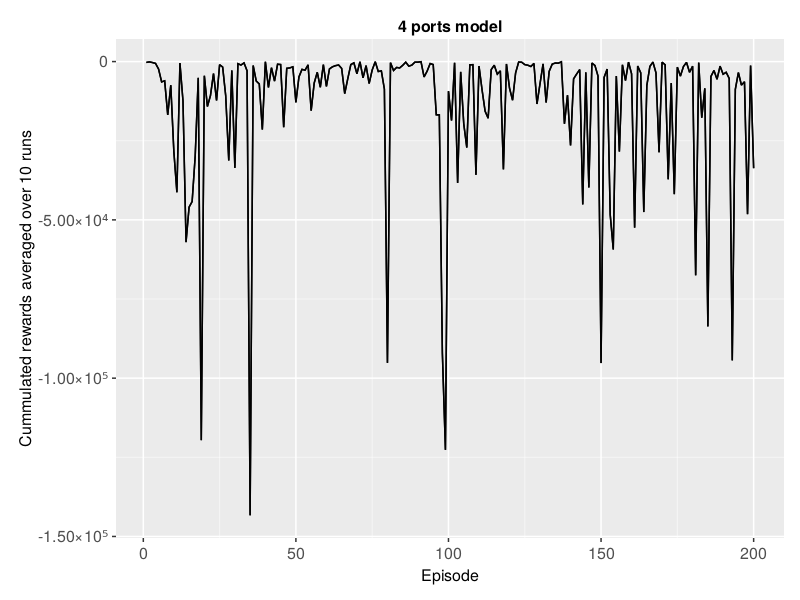

In [7]:
create_plot(plot_avg_cum_rewards; title=title, backgroundcolor=:white, open_plot=false, n_runs=n_runs, n_episodes=n_episodes, df=df, rewards=rewards)

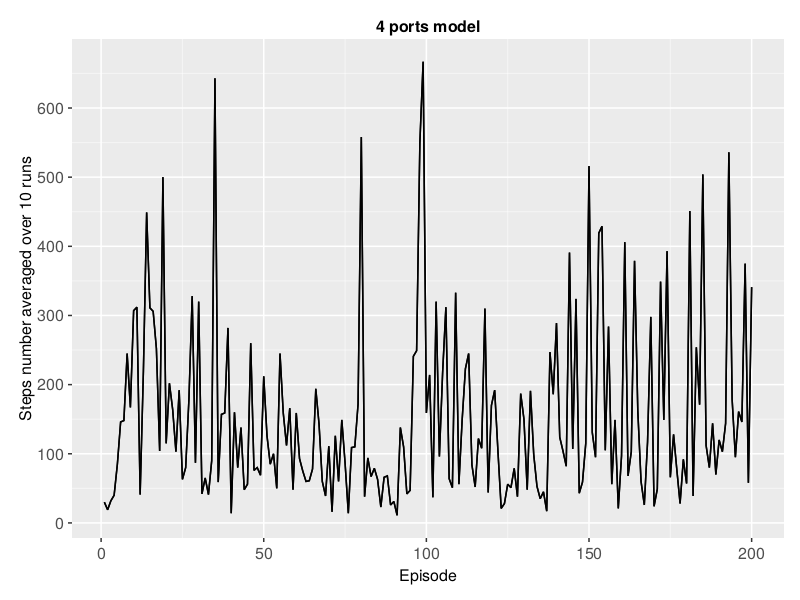

In [8]:
create_plot(plot_avg_steps; title=title, backgroundcolor=:white, open_plot=false, n_runs=n_runs, n_episodes=n_episodes, df=df, steps=steps)

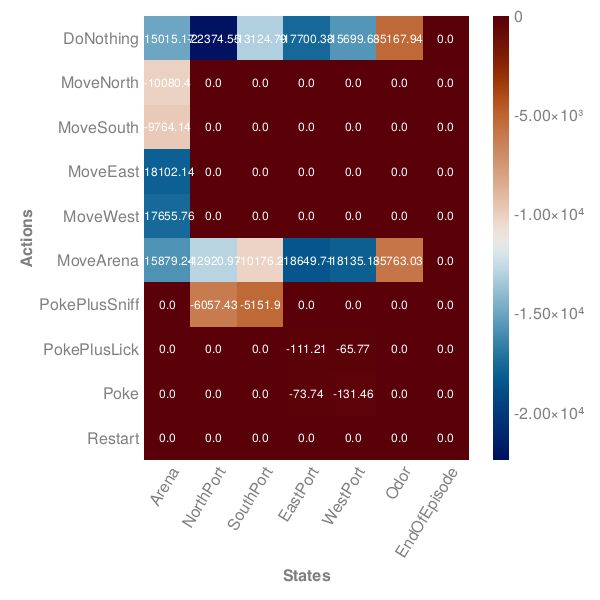

In [9]:
create_plot(plot_policy; title=title, backgroundcolor=:white, open_plot=false, theme=theme_light, policy_table=agent.policy.learner.approximator.table)